In [1]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/rnaveiro/anaconda3/envs/numpyro_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset

In [2]:
boston = fetch_openml(name="boston", version=1, as_frame=False)
X = boston.data
y = boston.target

# Scale features

In [3]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_interactions)

# Train-test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Bayesian Linear Regression with Horseshoe Prior

In [5]:
def model(X, y=None):
    n_features = X.shape[1]
    local_shrinkage = numpyro.sample('local_shrinkage', dist.HalfCauchy(scale=1.0).expand([n_features]).to_event(1))
    global_shrinkage = numpyro.sample('global_shrinkage', dist.HalfCauchy(scale=1.0))
    tau = global_shrinkage * local_shrinkage
    beta = numpyro.sample('beta', dist.Normal(0, tau))
    intercept = numpyro.sample('intercept', dist.Normal(0, 1))
    mu = jnp.dot(X, beta) + intercept
    sigma = numpyro.sample('sigma', dist.HalfCauchy(scale=1.0))
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=y)

## MCMC

In [6]:
num_samples = 1000
num_warmup = 500
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, progress_bar=True)
mcmc.run(jax.random.PRNGKey(0), X_train, y_train)
mcmc.print_summary()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


sample: 100%|██████████| 1500/1500 [00:15<00:00, 96.16it/s, 511 steps of size 6.25e-03. acc. prob=0.86]  



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
            beta[0]     -0.97      2.59     -0.18     -5.34      1.87    132.58      1.00
            beta[1]     -1.16      2.26     -0.43     -5.09      1.55    117.61      1.01
            beta[2]      0.63      1.93      0.12     -1.55      4.37    151.36      1.00
            beta[3]      5.86      4.78      5.31     -0.63     12.71     78.22      1.01
            beta[4]      0.36      1.34      0.06     -1.61      2.20    240.55      1.00
            beta[5]     12.89      2.50     12.74      9.27     17.11     54.16      1.00
            beta[6]      1.52      2.84      0.33     -1.66      6.07    227.53      1.00
            beta[7]     -1.83      3.00     -0.81     -5.51      2.05     86.54      1.00
            beta[8]     14.94     12.87     16.26     -1.22     32.30     14.92      1.00
            beta[9]      6.62      9.85      0.69     -3.65     23.60     14.09      1.00
         

# Plot posterior mean for coefficients with 95% probability interval

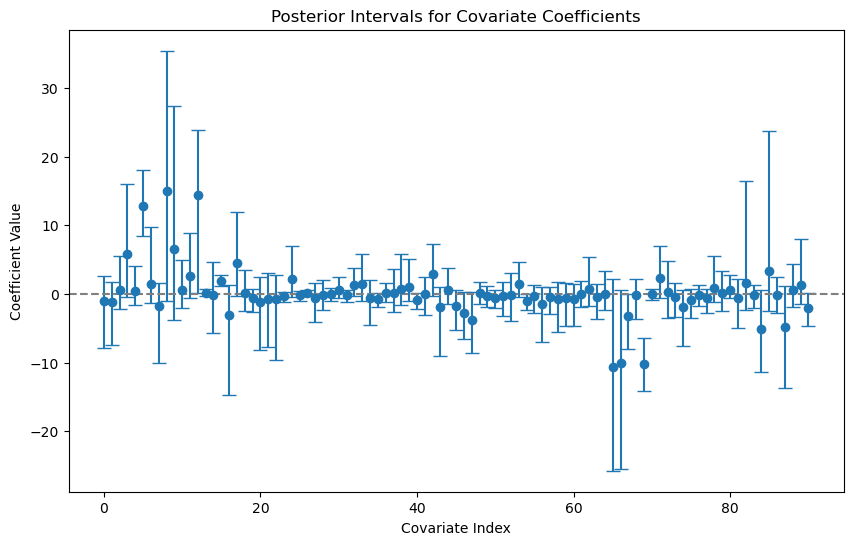

In [10]:
# Posterior samples from betas
beta_samples = posterior_samples['beta']

# Mean and credible intervals for betas
beta_means = jnp.mean(beta_samples, axis=0)
beta_lower = jnp.percentile(beta_samples, 2.5, axis=0)
beta_upper = jnp.percentile(beta_samples, 97.5, axis=0)

# Plot for feature importance
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(beta_means)), beta_means, yerr=[beta_means - beta_lower, beta_upper - beta_means], fmt='o', capsize=5)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Covariate Index')
plt.ylabel('Coefficient Value')
plt.title('Posterior Intervals for Covariate Coefficients')
plt.show()

# Sample from Predictive

In [11]:
posterior_samples = mcmc.get_samples()
predictive = Predictive(model, posterior_samples)
predictions = predictive(jax.random.PRNGKey(1), X_test)['obs']
pred_mean = jnp.mean(predictions, axis=0)

In [12]:
mse = mean_squared_error(y_test, pred_mean)
r2 = r2_score(y_test, pred_mean)
print(f'Mean Squared Error on Test Set: {mse}')
print(f'R² on Test Set: {r2}')

Mean Squared Error on Test Set: 11.23686385990292
R² on Test Set: 0.8467709781815458


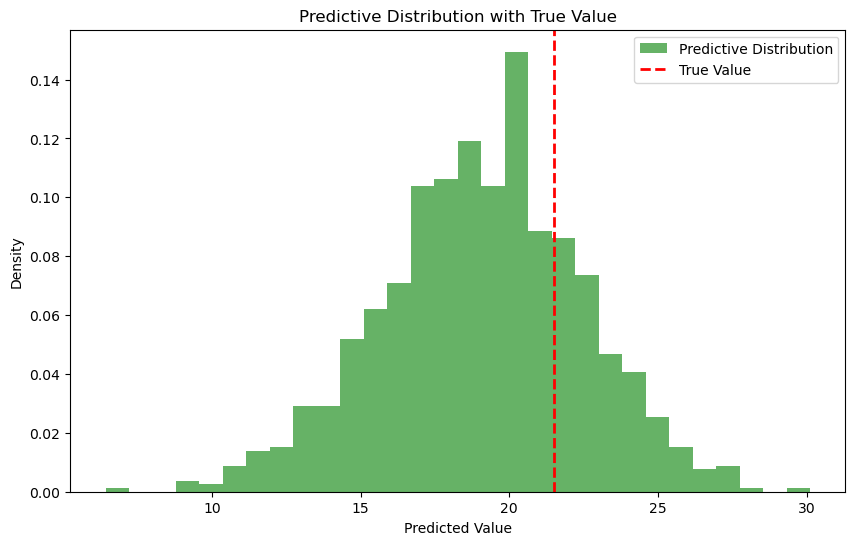

In [15]:
# Choose an index for a real observation
index = 10

# Extract the predictive distribution for the chosen observation
predictive_dist = predictions[:, index]

# Plot the histogram of the predictive distribution
plt.figure(figsize=(10, 6))
plt.hist(predictive_dist, bins=30, density=True, alpha=0.6, color='g', label='Predictive Distribution')

# Plot the true value as a vertical line
true_value = y_test[index]
plt.axvline(true_value, color='r', linestyle='--', linewidth=2, label='True Value')

# Add labels and title
plt.xlabel('Predicted Value')
plt.ylabel('Density')
plt.title('Predictive Distribution with True Value')
plt.legend()
plt.show()

# Laplace Approximation of Predictive Distribution

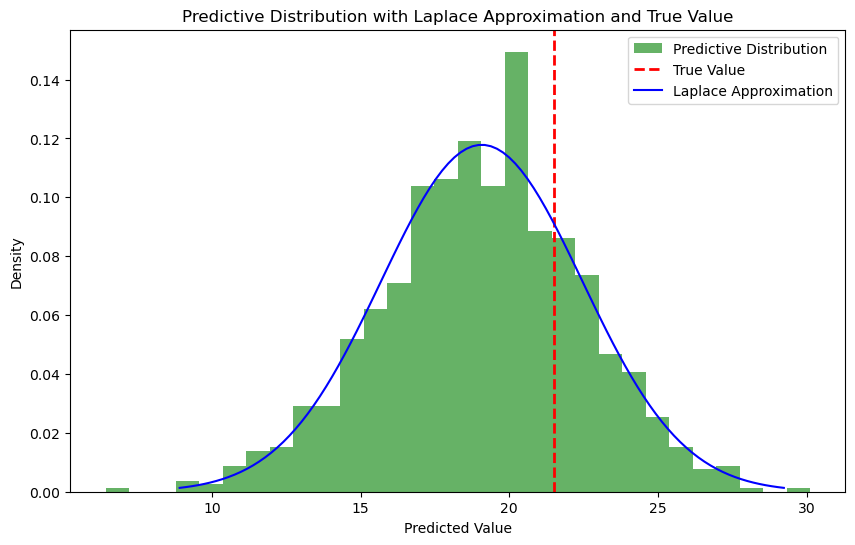

In [16]:
from scipy.stats import norm

# Compute the mean and standard deviation of the predictive distribution
predictive_mean = jnp.mean(predictive_dist)
predictive_std = jnp.std(predictive_dist)

# Generate a range of values for the x-axis
x_values = jnp.linspace(predictive_mean - 3 * predictive_std, predictive_mean + 3 * predictive_std, 100)

# Compute the Laplace approximation (Gaussian) of the predictive distribution
laplace_approx = norm.pdf(x_values, loc=predictive_mean, scale=predictive_std)

# Plot the histogram of the predictive distribution
plt.figure(figsize=(10, 6))
plt.hist(predictive_dist, bins=30, density=True, alpha=0.6, color='g', label='Predictive Distribution')

# Plot the true value as a vertical line
plt.axvline(true_value, color='r', linestyle='--', linewidth=2, label='True Value')

# Plot the Laplace approximation
plt.plot(x_values, laplace_approx, 'b-', label='Laplace Approximation')

# Add labels and title
plt.xlabel('Predicted Value')
plt.ylabel('Density')
plt.title('Predictive Distribution with Laplace Approximation and True Value')
plt.legend()
plt.show()

In [36]:
def kl_divergence(mu_A, sigma_A, mu_B, sigma_B):
    """
    Compute the KL divergence between two normal distributions.
    
    Parameters:
    mu_A (float): Mean of the first normal distribution.
    sigma_A (float): Standard deviation of the first normal distribution.
    mu_B (float): Mean of the second normal distribution (Laplace approximation).
    sigma_B (float): Standard deviation of the second normal distribution (Laplace approximation).
    
    Returns:
    float: The KL divergence.
    """
    return np.log(sigma_B / sigma_A) + (sigma_A**2 + (mu_A - mu_B)**2) / (2 * sigma_B**2) - 0.5


mu_A = 15.0  # Mean of adversarial target distribution
sigma_A = 3.0 # Std of adversarial target distribution
mu_B = float(predictive_mean)  # Mean of the Laplace approximation
sigma_B = float(predictive_std)  # Std of the Laplace approximation

kl_div = kl_divergence(mu_A, sigma_A, mu_B, sigma_B)
print(f"KL Divergence: {kl_div}")

KL Divergence: 0.7371250690173872
